# Using the MUA Pipeline for **CPM** and **PNRS**

**Authors**: Fatemeh Doshvargar + Hallee Shearer
**Date**: Feb 11, 2026


## Setup
Install and load the MUA Pipeline and other dependencies

In [ ]:
%%bash
pip install git+https://github.com/FatemehDoshvargar/_MUA_Pipeline.git # will only work once hallee's brach is merged to main
pip install -r requirements.txt

  Cloning https://github.com/halleeshearer/_MUA_Pipeline.git (to revision library) to /private/var/folders/yj/ydf36qzd6gnfd0pl7wdmdd0w0000gp/T/pip-req-build-tf3wo004


  Running command git clone --filter=blob:none --quiet https://github.com/halleeshearer/_MUA_Pipeline.git /private/var/folders/yj/ydf36qzd6gnfd0pl7wdmdd0w0000gp/T/pip-req-build-tf3wo004
  Running command git checkout -b library --track origin/library
  Switched to a new branch 'library'
  branch 'library' set up to track 'origin/library'.


  Resolved https://github.com/halleeshearer/_MUA_Pipeline.git to commit a3d855d5af0a499be6e9e7ecad1174bb1c693626
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# import the MUA package
from mua_pipeline import FeatureVectorizer, MUA, preprocess, plot_results

# other imports
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

## Data

For this example, we will use simulated toy data.

In [4]:
# create toy data 
n_subjects = 1000
n_regions = 200

# Generate random connectivity matrices (3D: subjects x regions x regions)
np.random.seed(42)
connectivity_matrices = np.random.randn(n_subjects, n_regions, n_regions)

# Make them symmetric (like real connectivity matrices)
for i in range(n_subjects):
    connectivity_matrices[i] = (connectivity_matrices[i] + connectivity_matrices[i].T) / 2
    np.fill_diagonal(connectivity_matrices[i], 1.0)  # Set diagonal to 1

# Generate behavioral scores with some relationship to connectivity
behavioral_scores = np.random.randn(n_subjects) * 10 + 100

print(f"✓ Data created: {connectivity_matrices.shape} connectivity, {behavioral_scores.shape} behavioral")


✓ Data created: (1000, 200, 200) connectivity, (1000,) behavioral


## Preprocessing

Clean the data with the preprocess function

In [5]:
clean_conn, clean_behav, removed = preprocess(
    connectivity_matrices, 
    behavioral_scores,
    missing_strategy='any',
    verbose=True
)

No subjects with missing data found.


## Create CPM Pipeline

CPM R² (10-fold CV): -0.083 ± 0.077
Correlation: r=0.077, p=1.51e-02
R²: -0.067
MAE: 8.554
RMSE: 10.652


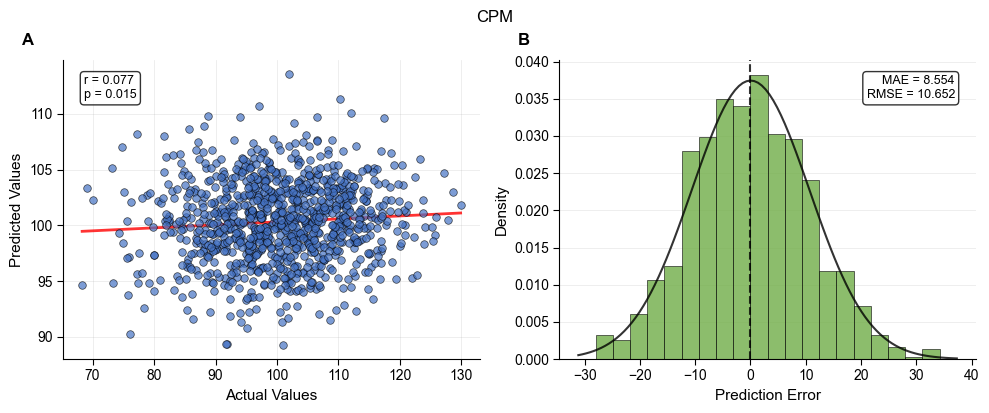

In [6]:
cpm_pipeline = Pipeline([
    ('vectorize', FeatureVectorizer()),
    ('mua', MUA(
        split_by_sign=True,
        selection_method='pvalue',
        selection_threshold=0.05,
        weighting_method='binary',
        feature_aggregation='sum',
    )),
    ('regressor', LinearRegression())
])

# cross-validation
cpm_scores = cross_val_score(cpm_pipeline, clean_conn, clean_behav, cv=10)
cpm_predictions = cross_val_predict(cpm_pipeline, clean_conn, clean_behav, cv=10)

# print results of cross validation
print(f"CPM R² (10-fold CV): {cpm_scores.mean():.3f} ± {cpm_scores.std():.3f}")

# compute metrics
cpm_r, cpm_p = pearsonr(clean_behav, cpm_predictions)
mae = mean_absolute_error(clean_behav, cpm_predictions)
rmse = np.sqrt(mean_squared_error(clean_behav, cpm_predictions))
r2 = r2_score(clean_behav, cpm_predictions)

# print metrics
print(f"Correlation: r={cpm_r:.3f}, p={cpm_p:.2e}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# plot results
plot_results(cpm_predictions, clean_behav, title="CPM")

## Create PNRS Pipeline

PNRS scores shape: (1000, 1)
Correlation: r=0.454, p=3.99e-52
R²: -35888.901
MAE: 1890.902
RMSE: 1953.252


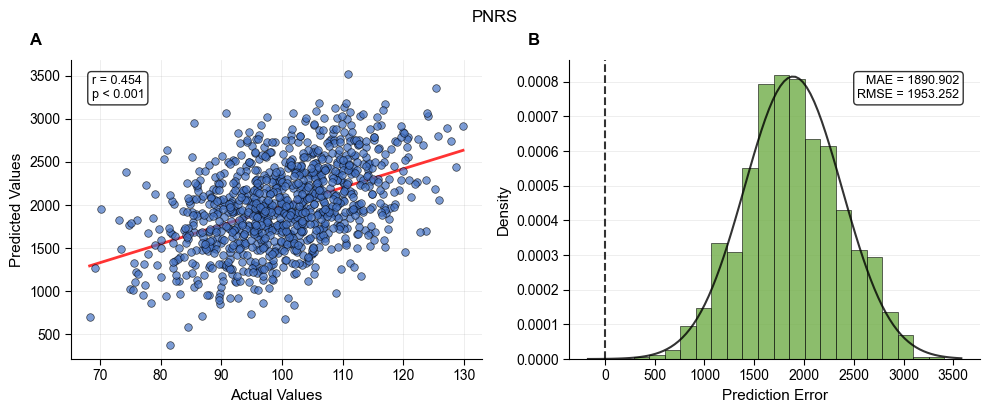

In [7]:
pnrs_pipeline = Pipeline([
        ('vectorize', FeatureVectorizer()),
        ('mua', MUA(
            split_by_sign=False,
            selection_method='all',
            weighting_method='regression',
            feature_aggregation='sum',
        ))
    ])


pnrs_scores = pnrs_pipeline.fit_transform(clean_conn, clean_behav)

# Use scores directly as predictions
pnrs_predictions = pnrs_scores.flatten()

# Compute metrics
pnrs_r, pnrs_p = pearsonr(clean_behav, pnrs_predictions)
mae = mean_absolute_error(clean_behav, pnrs_predictions)
rmse = np.sqrt(mean_squared_error(clean_behav, pnrs_predictions))

r2 = r2_score(clean_behav, pnrs_predictions)

# print metrics
print(f"PNRS scores shape: {pnrs_scores.shape}")
print(f"Correlation: r={pnrs_r:.3f}, p={pnrs_p:.2e}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# plot results
plot_results(pnrs_predictions, clean_behav, title="PNRS")